In [1]:
import galsim
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
# Meta-parameter
n_star = 400
wid_strip, n_strip = 8, 32
mu = 884
sigma = 1e-1

In [3]:
# Image Parameter
image_size = 501
pixel_scale = 2.5                                # arcsec/pixel

# PSF Parameters
beta = 10                                        # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                        # moffat FWHM, in arcsec

n0 = 3.3                                         # true power index
frac = 0.1                                       # fraction of power law component
theta_0 = 5.                                     # radius at which power law is flattened, in arcsec

n_s = np.array([n0, 3, 2.4, 2., 1.4, 4])
theta_s = np.array([theta_0, 60, 120, 200, 320, 900])      # transition radius in arcsec

In [4]:
# Single-power PSF
params_pow = {"fwhm":fwhm, "beta":beta, "frac":frac, "n":n0, 'theta_0':theta_0}
psf = PSF_Model(params=params_pow, aureole_model='power')

In [4]:
# Multi-power PSF
params_mpow = {"fwhm":fwhm, "beta":beta, "frac":frac, "n_s":n_s, 'theta_s':theta_s}
psf = PSF_Model(params=params_mpow, aureole_model='multi-power')

In [5]:
# Build grid of image for drawing
psf.make_grid(image_size, pixel_scale=pixel_scale)

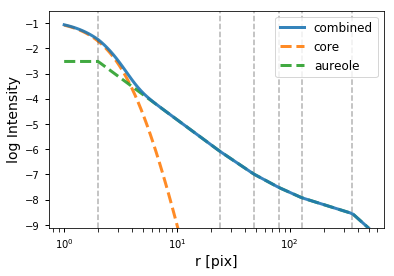

In [6]:
# Plot analytical 1D profile
psf.plot1D(psf_range=500)

# of medium bright (flux:1.1e+05~4.1e+05) stars: 11 
# of very bright (flux>5.6e+06) stars : 4
Not many bright stars, will draw in serial.



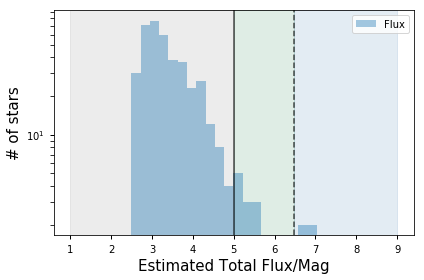

In [10]:
# Star Distribution (position, flux)
############################################

# Generate randomn star positions
np.random.seed(626)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[SE_cat_full['FLAGS']<8]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(888)
Flux = Flux_Auto_SE.sample(n=n_star).values

Flux[Flux>5e5] *= 10

# Thresholds depending on the actual PSF, noise level, magnitude distribution of stars, which affect speed and accuracy.
# Faint stars are rendered with fixed PSF in advance. Very bright stars are rendered in real space.
F_bright = 1e5
F_verybright = 3e6

stars = Stars(star_pos, Flux, Flux_threshold=[F_bright, F_verybright], verbose=True)
stars.plot_flux_dist(label='Flux')

In [11]:
# Generate core and (initial) aureole PSF
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e6, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e
psf0 = psf.copy()

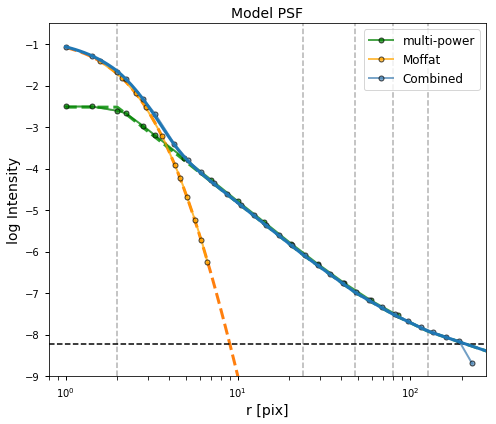

In [12]:
# Galsim 2D model averaged in 1D
Amp_m = psf.Flux2Amp(Flux).max()
contrast = Amp_m / sigma
psf.plot_model_galsim(psf_c, psf_e, image_size, contrast=contrast)

Generate noise background w/ stddev = 0.1
Generate base image of faint stars (flux < 1e+05).
Total Time: 0.326 s

Generate the truth image.
Rendering bright stars in parallel...
Number of CPU free cores set to: 1 given that the CPU has 4 logical cores.
No requested_cores given.  Using estimate of 3.
computational jobs per core = 10. For short computations, each core must have at least 20 jobs to warrant parallel computation.
Computations are not lengthy.
Not enough jobs per core. Reducing cores to 1
Rank 0 starting computing on 1 cores (requested None cores)
Rank 0 computing serially ...
Total Time: 0.698 s



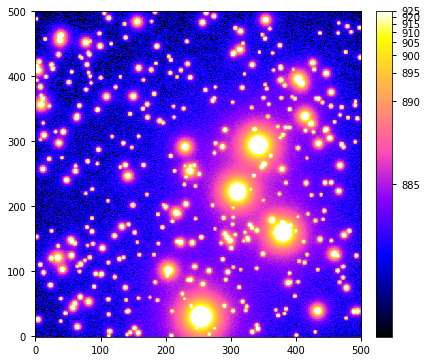

In [13]:
# Make noise image
noise_image = make_noise_image(image_size, sigma)

# Make sky background and dim stars
image_base = make_base_image(image_size, stars, psf_base=star_psf)

# Make truth image
image = make_truth_image(psf, stars, parallel=True, verbose=True)
image = image + image_base + mu + noise_image

# Display Truth
plt.figure(figsize=(7,6))
im = plt.imshow(image, vmin=mu, vmax=925, norm=norm1); colorbar(im)

Mask inner regions of stars in dual mode:  S/N > 2.5 / r < 36 (36) pix 
Use sky strips crossing very bright stars


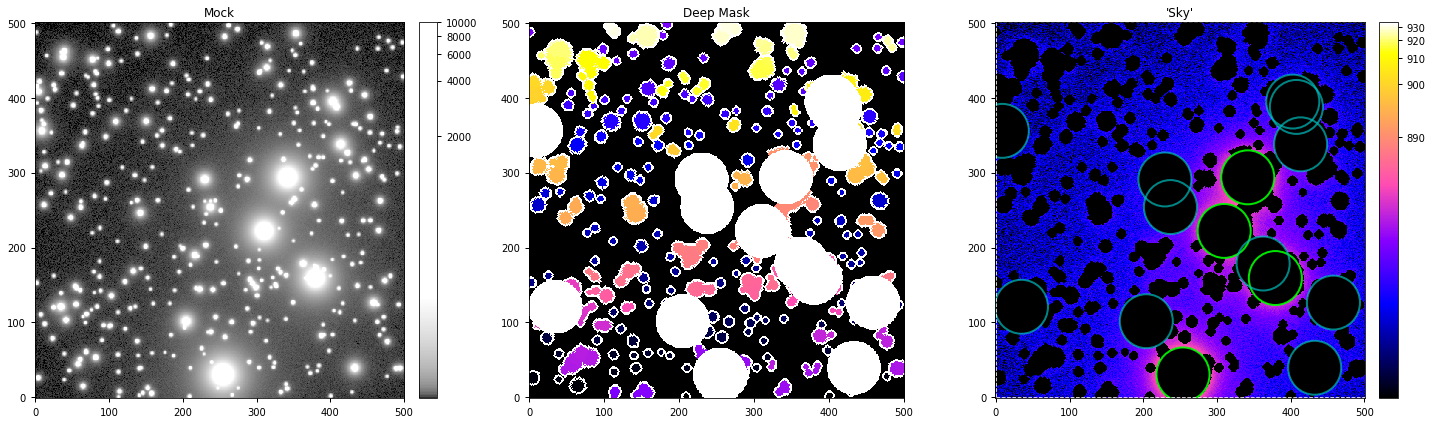

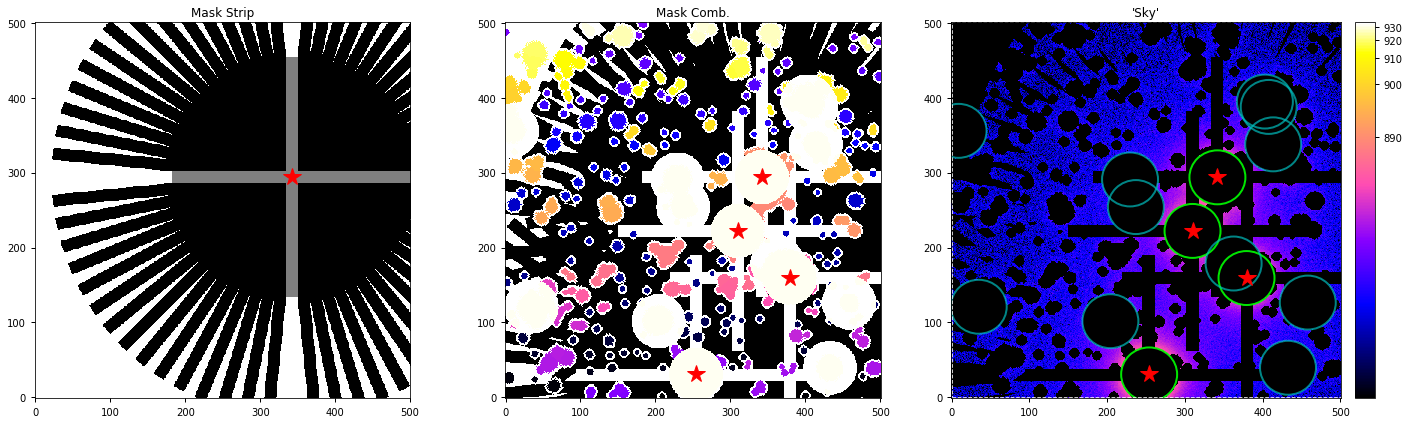

In [15]:
# Masking
mask = Mask(image, stars, image_size, mu=mu)

# Core mask
r_core_s = [36, 36]
mask.make_mask_map_dual(r_core_s, sn_thre=2.5, draw=True, n_dilation=3)

# Strip + Cross mask
mask.make_mask_strip(wid_strip, n_strip, dist_strip=320, clean=True, draw=True)
stars = mask.stars_new

In [16]:
%%timeit
image_tri = generate_mock_image(psf, stars, psf_range=640, brightest_only=True, draw_real=False)

196 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
image_tri = generate_mock_image(psf, stars, brightest_only=True, draw_real=True)

77.5 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test of generating mock images...
Done! Total Time: 0.299s



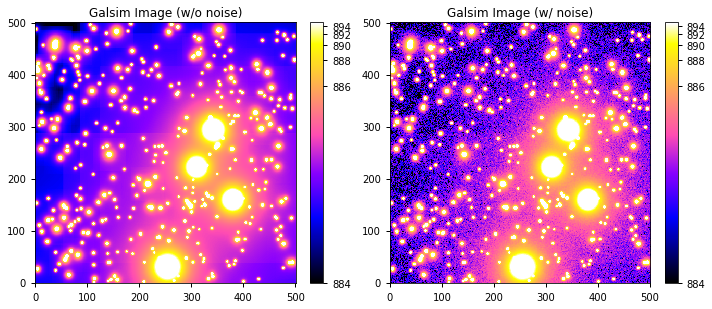

In [18]:
# Draw test
print("Test of generating mock images...")
start = time.time()

image_tri = generate_mock_image(psf, stars, psf_range=640, brightest_only=True, draw_real=False)
image_tri = image_tri + image_base + mu
end = time.time()
print("Done! Total Time: %.3fs\n"%(end-start))

# Compare mock and truth
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
im = ax1.imshow(image_tri, vmin=mu, vmax=mu+11, norm=norm1); colorbar(im)
im = ax2.imshow(image_tri + noise_image, vmin=mu, vmax=mu+11, norm=norm1); colorbar(im)
ax1.set_title("Galsim Image (w/o noise)")
ax2.set_title("Galsim Image (w/ noise)")
plt.tight_layout()   

In [19]:
# Fitting Preparation
############################################ 
mask_fit = mask.mask_comb

X = np.array([psf.xx,psf.yy])
Y = image[~mask_fit].copy().ravel()

# Estimated mu and sigma used as prior
Y_clip = sigma_clip(Y, sigma=3, maxiters=10)
mu_patch, std_patch = np.mean(Y_clip), np.std(Y_clip)
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))

Estimate of Background: (884.257, 0.166)


### Bi-power Law

In [20]:
# Priors and Likelihood Models for Fitting
############################################

labels = [r'$n0$', r'$n1$', r'$\theta_1$', r'$\mu$', r'$\log\,\sigma$']
truths = np.concatenate([[n_s[0], n_s[-2]], [np.log10(theta_s[-2])], [mu, np.log10(sigma)]])

ndim = len(labels)
print("Truths: ", np.around(truths, 3))
print("Labels: ", labels)

def prior_tf_2p(u):
    v = u.copy()
    v[0] = u[0] * 0.6 + 3             # n0 : 3-3.6
    v[1] = u[1] * (v[0]-1.2) + 1.2    # n1 : 1.2-n0
    v[2] = u[2] * 0.8 + 1.7           # log theta1 : 50-300  # in arcsec
    v[-2] = stats.truncnorm.ppf(u[-2], a=-2, b=0.1,
                                loc=mu_patch, scale=std_patch)         # mu
    v[-1] = stats.truncnorm.ppf(u[-1], a=-1, b=0.1,
                                loc=np.log10(std_patch), scale=0.5)    # log sigma 
    return v

def loglike_2p(v):
    n_s = v[:2]
    theta_s = [theta_0, 10**v[2]]
    mu, sigma = v[-2], 10**v[-1]
    
    psf.update({'n_s':n_s, 'theta_s':theta_s})
    
    image_tri = generate_mock_image(psf, stars, psf_range=640,
                                    brightest_only=True, parallel=False, draw_real=False)
    image_tri = image_tri + image_base + mu 
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


Truths:  [  3.3     1.4     2.505 884.     -1.   ]
Labels:  ['$n0$', '$n1$', '$\\theta_1$', '$\\mu$', '$\\log\\,\\sigma$']


In [29]:
# Run & Plot
############################################
ds = DynamicNestedSampler(loglike_2p, prior_tf_2p, ndim)
ds.run_fitting(nlive_init=100, nlive_batch=25, maxbatch=2, close_pool=False)

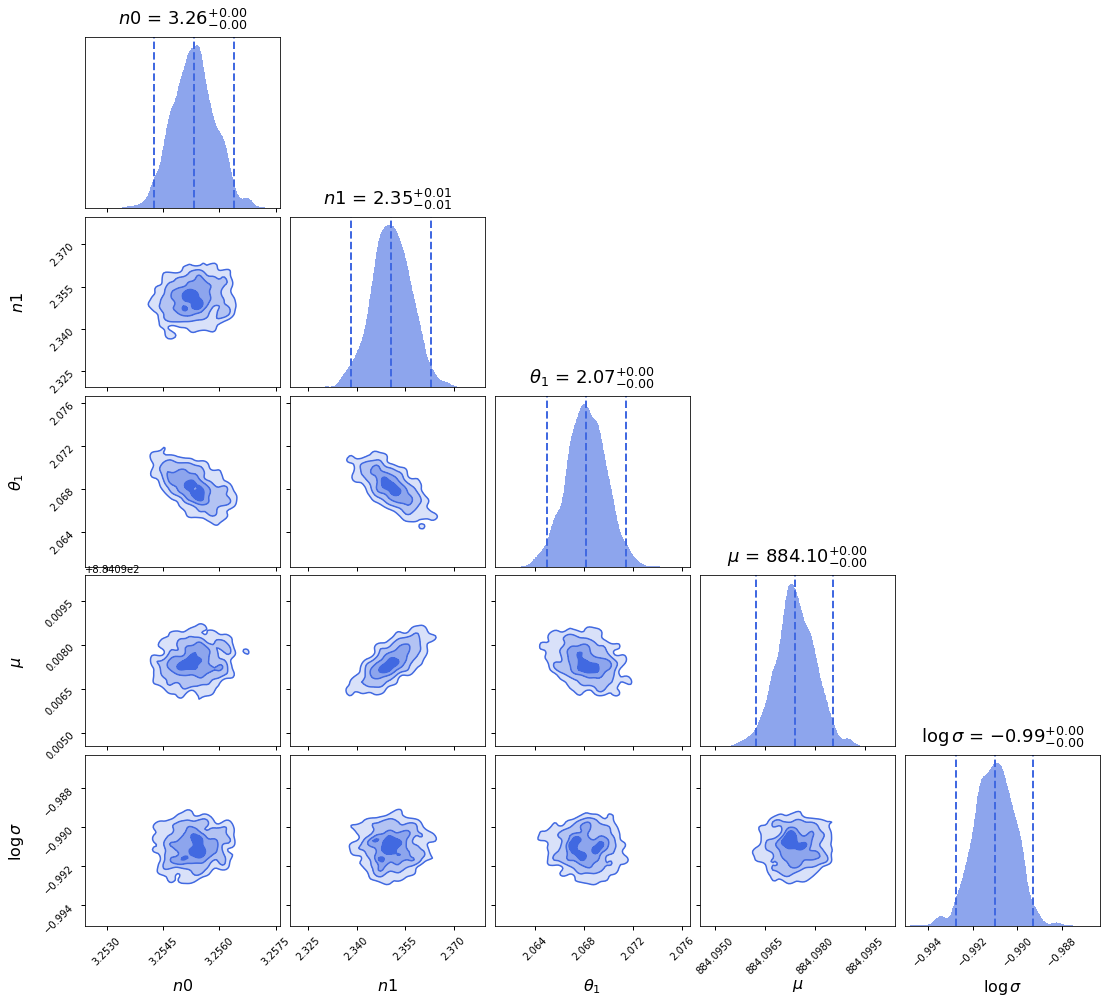

In [22]:
ds.cornerplot(labels=labels)

In [23]:
ds.close_pool()


Pool Closed.


Fitting (mean) :  [  3.255   2.351   2.068 884.097  -0.991]
Fitting (median) :  [  3.255   2.351   2.068 884.097  -0.991]
Truth :  [3.3 3.  2.4 2.  1.4 4. ]


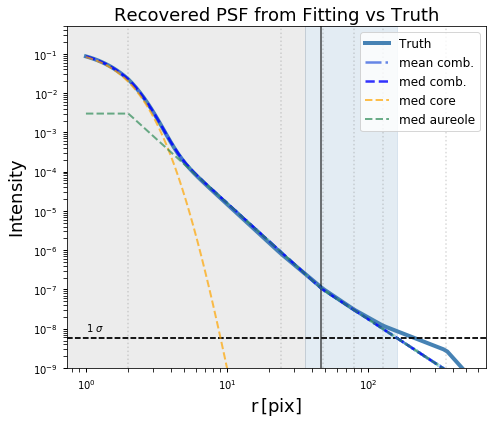

In [24]:
plot1D_fit_vs_truth_PSF_mpow(ds.results, psf0, labels, n_bootstrap=800,
                             Amp_max=Amp_m, r_core=r_core_s, save=False, dir_name=".")

Run Nested Fitting for the image... Dim of params: 5
Opening pool: # of CPU used: 3


iter: 3573 | batch: 2 | bound: 130 | nc: 2 | ncall: 23328 | eff(%): 15.316 | loglstar: 46556.866 < 46560.933 < 46558.166 | logz: 46531.869 +/-  0.735 | stop:  4.450                                  


Finish Fitting! Total time elapsed: 749s


/home/qliu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/qliu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


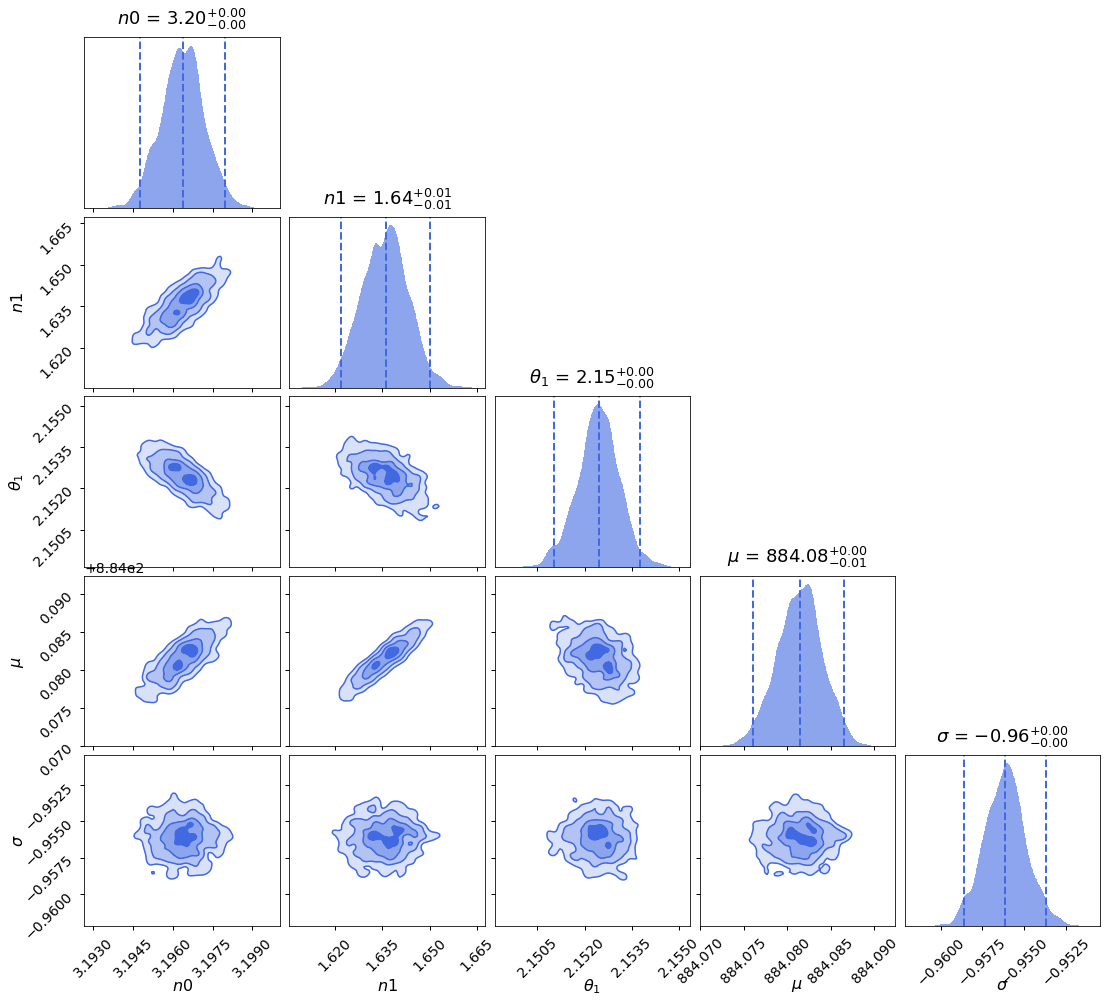

In [89]:
# Run & Plot
############################################

# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike_2p, prior_tf_2p, ndim, nlive_init=100)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, truths=truths, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':16}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(16, 14)))

Fitting (mean):  [  3.19636647   1.63585978   2.15243885 884.08143256  -0.95613044]
Fitting (median):  [  3.19636597   1.63606015   2.15245103 884.08151809  -0.95613055]


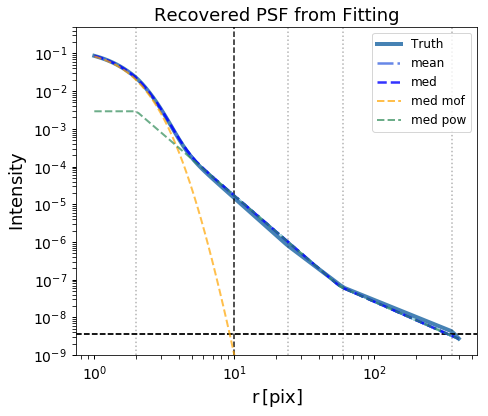

In [106]:
plot1D_fit_vs_truth_PSF_mpow(pdres, psf0, labels, n_bootstrap=800,
                             Amp_max=Amp_m, r_core=r_core_s, save=False, dir_name=".")

### Tri-power law

In [150]:
# Priors and Likelihood Models for Fitting
labels = [r'$n0$', r'$n1$', r'$n2$', r'$\theta_1$', r'$\theta_2$', r'$\mu$', r'$\log\,\sigma$']

ndim = len(labels)
print("Labels: ", labels)

def prior_tf_3p(u):
    v = u.copy()
    v[0] = u[0] * 0.8 + 2.7                 # n0 : 2.7-3.5
    v[1] = u[1] * 0.8 + (v[0]-1)            # n1 : n0-1 - n0-0.2
    v[2] = max(u[2] * 0.8 + (v[1]-1) ,1)    # n2 : [1,n1-1] - n1-0.2
    v[3] = u[3] * 0.8 + 1.7                 # log theta1 : 50-300  # in arcsec
    v[4] = u[4] * (2.7-2*v[3]) + 2*v[3]     # log theta2 : 2 * theta1 - 500  # in arcsec
    v[-2] = stats.truncnorm.ppf(u[-2], a=-2, b=0.1,
                                loc=mu_patch, scale=std_patch)         # mu
    v[-1] = stats.truncnorm.ppf(u[-1], a=-1, b=0.1,
                                loc=np.log10(std_patch), scale=0.5)    # log sigma 
    return v

def loglike_3p(v):
    n_s = v[:3]
    theta_s = [theta_0, 10**v[3], 10**v[4]]
    mu, sigma = v[-2], 10**v[-1]
    
    psf.update({'n_s':n_s, 'theta_s':theta_s})
    
    image_tri = generate_mock_image(psf, stars, brightest_only=True, parallel=False, draw_real=True)
    image_tri = image_tri + image_base + mu 
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


Labels:  ['$n0$', '$n1$', '$n2$', '$\\theta_1$', '$\\theta_2$', '$\\mu$', '$\\log\\,\\sigma$']


In [ ]:
# Run & Plot
############################################
ds = DynamicNestedSampler(loglike_3p, prior_tf_3p, ndim)
ds.run_fitting(nlive_init=70, nlive_batch=25, maxbatch=2, close_pool=False)

ds.cornerplot(labels=labels, figsize=(18, 16))

Run Nested Fitting for the image... Dim of params: 7
Opening pool: # of CPU used: 3


iter: 5985 | batch: 2 | bound: 264 | nc: 5 | ncall: 52703 | eff(%): 11.356 | loglstar: 242783.895 < 242789.502 < 242789.401 | logz: 242754.206 +/-  0.679 | stop:  3.812                              


Finish Fitting! Total time elapsed: 1.05e+04s


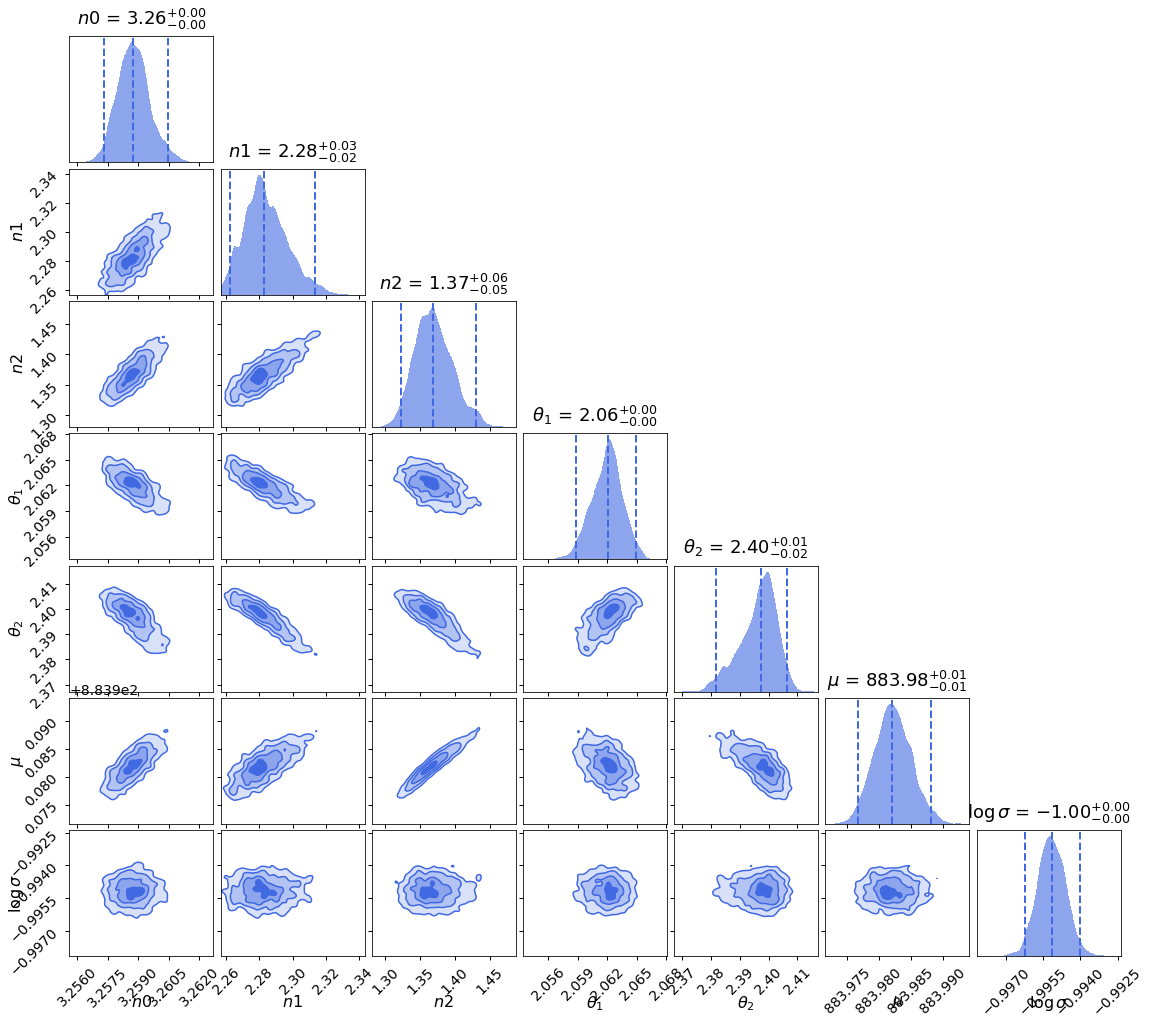

In [151]:
# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike_3p, prior_tf_3p, ndim,
                                       nlive_init=100, nlive_batch=20, maxbatch=2)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':16}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(18, 16)))

Fitting (mean) :  [  3.259   2.284   1.37    2.062   2.396 883.982  -0.995]
Fitting (median) :  [  3.259   2.283   1.368   2.062   2.397 883.982  -0.995]
Truth :  [3.3 3.  2.4 2.  1.4 4. ]


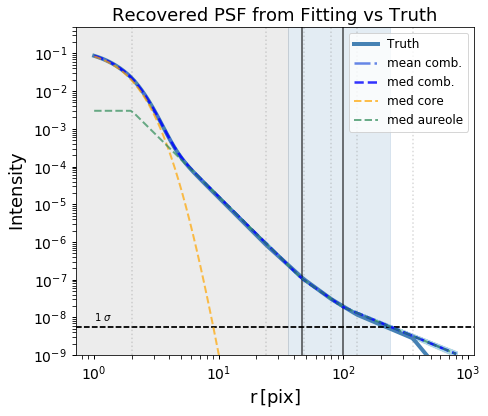

In [267]:
plot1D_fit_vs_truth_PSF_mpow(pdres, psf0, labels, n_bootstrap=800,
                             Amp_max=Amp_m, r_core=r_core_s, save=False, dir_name=".")

Fitting (mean) :  [  3.259   2.284   1.37    2.062   2.396 883.982  -0.995]
Fitting (median) :  [  3.259   2.283   1.368   2.062   2.397 883.982  -0.995]
Generate noise background w/ stddev = 0.101


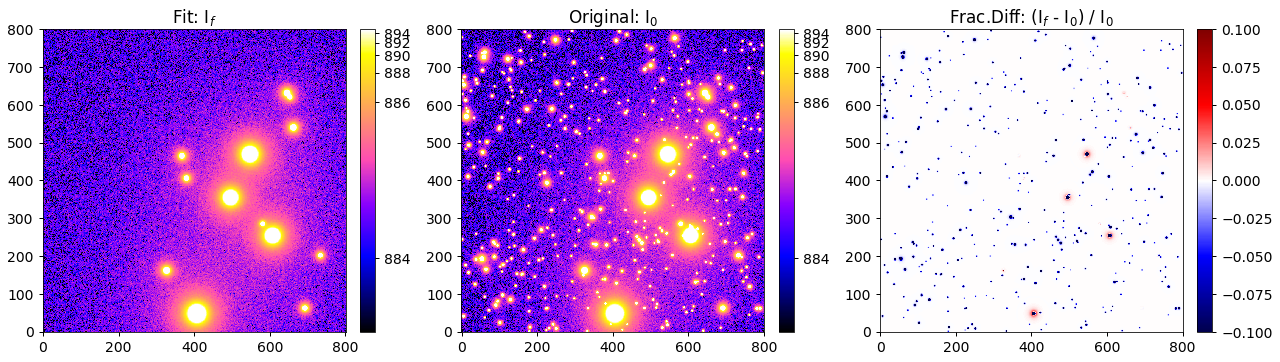

In [276]:
draw2D_fit_vs_truth_PSF_mpow(pdres,  psf0, stars, labels)

In [216]:
save_nested_fitting_result(pdres, filename='./Mock-fit_best_3p.res')

### Spline

In [67]:
# Priors and Likelihood Models for Fitting
nspline = 5
labels_sp = [r'$n_%d$'%d for d in range(nspline)] \
            + [r'$\theta_%d$'%(d+1) for d in range(nspline-1)] + [r'$\mu$', r'$\log\,\sigma$']

ndim_sp = len(labels_sp)
print("Labels: ", labels_sp)

def prior_tf_sp(u):
    v = u.copy()
    
    v[0] = u[0] * 0.8 + 2.7                                           # n0 : 2.7-3.5
    for k in range(nspline-1):
        v[k+1] = u[k+1] * max(-0.25, 1.25-v[1]) + (v[1]-0.25)         # n_k+1 : [1, n_k-0.5] - n_k-0.25
        
    v[nspline] = u[nspline] * 0.6 + 1.7                               # log theta1 : 50-200  # in arcsec
    
    for k in range(nspline-2):
        v[k+nspline+1] = u[k+nspline+1] * min(0.4, 2.4-v[k+nspline]) + v[k+nspline] + 0.3
        # log theta_k+1: 2*theta_k - [5*theta_k, 500]  # in arcsec

    v[-2] = stats.truncnorm.ppf(u[-2], a=-2, b=0.1,
                                loc=mu_patch, scale=std_patch)         # mu
    v[-1] = stats.truncnorm.ppf(u[-1], a=-1, b=0.1,
                                loc=np.log10(std_patch), scale=0.5)    # log sigma 
    return v

def loglike_sp(v):
    n_s = v[:nspline]
    theta_s = [theta_0] + (10**v[nspline:-2]).tolist()
    mu, sigma = v[-2], 10**v[-1]
    
    psf.update({'n_s':n_s, 'theta_s':theta_s})
    
    image_tri = generate_mock_image(psf, stars, brightest_only=True, parallel=False, draw_real=True)
    image_tri = image_tri + image_base + mu 
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


Labels:  ['$n_0$', '$n_1$', '$n_2$', '$n_3$', '$n_4$', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$', '$\\theta_4$', '$\\mu$', '$\\log\\,\\sigma$']


In [1]:
# Run & Plot
############################################
ds = DynamicNestedSampler(loglike_sp, prior_tf_sp, ndim_sp)
ds.run_fitting(nlive_init=110, nlive_batch=25, maxbatch=2)

ds.cornerplot(labels=labels, figsize=(22, 20))

### Single Power Law

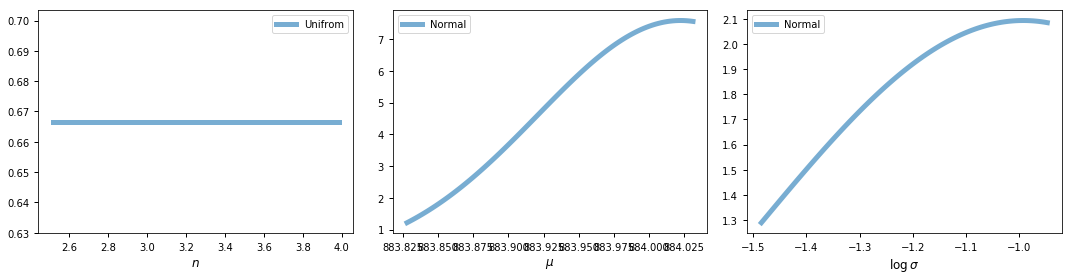

In [97]:
# Priors and Likelihood Models for Fitting
############################################

labels = [r'$n$', r'$\mu$', r'$\log\,\sigma$']
truths = n0, mu, np.log10(sigma)

ndim = len(labels)
print("Truths: ", np.around(truths, 3))
print("Labels: ", labels)

Prior_n = stats.uniform(loc=2.5, scale=1.5)                          # n : 2.5-4
Prior_mu = stats.truncnorm(a=-2, b=0.1, loc=mu_patch, scale=std_patch) # mu
Prior_sigma = stats.truncnorm(a=-1, b=0.1, loc=np.log10(std_patch), scale=0.5)   # sigma 

Priors = [Prior_n, Prior_mu, Prior_sigma]
prior_tf = build_priors(Priors)

draw_prior(Priors, xlabels=labels, plabels=['Unifrom','Normal','Normal'])

def loglike(v):
    n, mu = v[:-1]
    sigma = 10**v[-1]
    
    psf.update({'n':n})
    
    image_tri = generate_mock_image(psf, stars, brightest_only=True, draw_real=True,  parallel=False)
    image_tri = image_tri + image_base + mu 
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

Run Nested Fitting for the image... Dim of params: 3
Opening pool: # of CPU used: 3


iter: 1273 | batch: 2 | bound: 39 | nc: 1 | ncall: 4994 | eff(%): 25.491 | loglstar: 216609.473 < 216612.382 < 216611.592 | logz: 216596.677 +/-  0.686 | stop:  6.564                                


Finish Fitting! Total time elapsed: 1.86e+03s


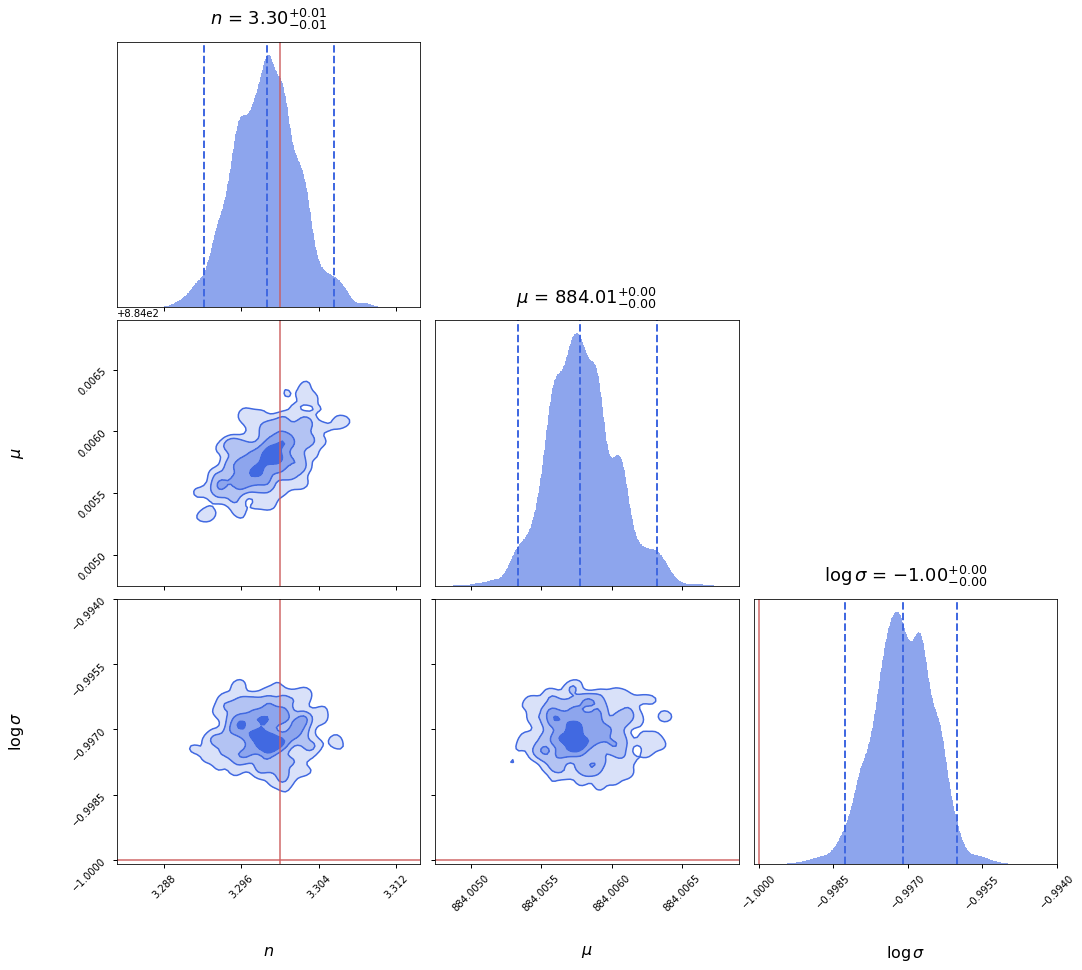

In [98]:
# Run & Plot
############################################

# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim, nlive_init=60, nlive_batch=20)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, truths=truths, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':16}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(12, 11)))